# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, isnan, explode, lit, count, when, sort_array, asc, avg, min, max, split, udf, isnull, countDistinct
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Users with NaNs in userIds or sessionIds are invalid users
# Drop invalid users
users = df.dropna(how = 'any', subset = ["userId", "sessionId"])
print('There are', users.count(), 'valid users')

There are 286500 valid users


In [6]:
# Check for duplicate users 
# Results show there are none bc valid_users counts are the same
users.select("userId").dropDuplicates().show()
users.count()

+------+
|userId|
+------+
|100010|
|200002|
|   125|
|    51|
|   124|
|     7|
|    54|
|    15|
|   155|
|   132|
|   154|
|100014|
|   101|
|    11|
|   138|
|300017|
|    29|
|    69|
|100021|
|    42|
+------+
only showing top 20 rows



286500

In [7]:
# Filter out empty userIds
valid_users = users.filter(users['userId'] != "")
print('After cleaning the data, there are', valid_users.count(), 'valid user entries.')

After cleaning the data, there are 278154 valid user entries.


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
# Explore values in page feature
valid_users.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [9]:
# Show how many cancelled which gives direct count of churn population
# Get Churn Ids
churn_users = valid_users.filter(valid_users["page"] == "Cancellation Confirmation")\
    .select("userId").dropDuplicates()

print("There are", churn_users.count(), "out of", valid_users.select("userId").dropDuplicates().count(), "users that cancelled")

There are 52 out of 225 users that cancelled


#### Note:
People that cancelled represent less than 25% of the population. Data imbalance is something to keep in mind when choosing the ML model and metrics.

### Question 1.  Is there a churn rate difference between gender?

In [10]:
# Get list of churn population
churn_users_ls = [user["userId"] for user in churn_users.collect()]

# Create churn column
valid_users = valid_users.withColumn("churn", valid_users.userId.isin(churn_users_ls))

# Show table of churn counts based on gender
gender_compare = valid_users.dropDuplicates(['userId'])\
    .groupby(['gender','churn']).count().sort("gender")

gender_compare.show()

# Get churn rates based on Gender
total_F_users = valid_users.select("userId", "churn")\
    .where(valid_users.gender == "F").dropDuplicates().count()

churn_F = valid_users.select("userId")\
    .where((valid_users.churn == 1) & (valid_users.gender =='F'))\
    .dropDuplicates().count()

total_M_users = valid_users.select("userId", "churn").where(valid_users.gender == "M")\
    .dropDuplicates().count()

churn_M = valid_users.select("userId")\
                            .where((valid_users.churn == 1) & (valid_users.gender =='M')).dropDuplicates().count()

churn_rate_F = churn_F / total_F_users
churn_rate_M = churn_M / total_M_users

print("Churn rate of female users: %.2f"%churn_rate_F)
print("Churn rate of male users: %.2f"%churn_rate_M)

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F| true|   20|
|     F|false|   84|
|     M| true|   32|
|     M|false|   89|
+------+-----+-----+

Churn rate of female users: 0.19
Churn rate of male users: 0.26


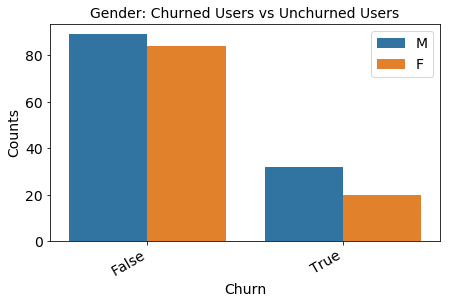

In [11]:
# Visualization
gender_df = gender_compare.toPandas()


fig = plt.figure(figsize=(7, 4));
sns.barplot(x='churn', y='count', hue='gender', 
            hue_order=['M', 'F'], data=gender_df );
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Churn", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("Gender: Churned Users vs Unchurned Users", fontsize=14 )
plt.xticks(rotation=30, ha='right', fontsize=14)
plt.legend(loc='best', fontsize=14);

#### Question 1. Results and discussion
It is shown that there is a difference in churn rates between genders where males have a higher churn rate.

### Question 2. What are the most active pages by the users? What can be said based on the distribution and relative differences between active and churned users.

In [12]:
churned= valid_users.filter(valid_users.churn==1)
active = valid_users.filter(valid_users.churn==0)

n_churned = churned.count()
n_active  = active.count()


churned_df= churned.filter(churned.page!="NextSong").groupby(["page"]).count()
churned_df= churned_df.withColumn("Churned", churned_df["count"]/(n_churned)).sort("page")

active_df = active.filter(active.page!="NextSong").groupby(["page"]).count()
active_df = active_df.withColumn("Active", active_df["count"]/(n_active)).sort("page")

churned_active_df = churned_df.join(active_df, "page", "outer").drop("count")\
    .fillna(0).toPandas()

churned_active_df.head()

page   Churned    Active
0            Cancel  0.001159  0.000000
1  Submit Downgrade  0.000201  0.000231
2       Thumbs Down  0.011056  0.008787
3              Home  0.037268  0.036050
4         Downgrade  0.007512  0.007364

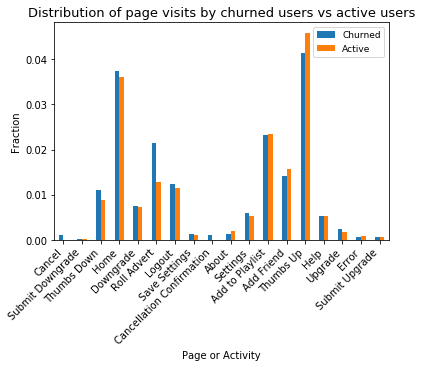

In [13]:
# Visualization
churned_active_df.plot.bar("page");
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Page or Activity", fontsize=10)
plt.ylabel("Fraction", fontsize=10)
plt.title("Distribution of page visits by churned users vs active users", fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(loc='best', fontsize=9);

#### Question 2. Results and discussion
As show by the figure above, there are differences in pages (and activities) between churned and active users. The higher fraction of the thumbs down page from the churned users suggest they did not like the content (music). The slightly higher downgrade fraction from the churned users suggest that there are signs, before a user churns; the churned population also has the higher upgrade fraction compared to the active users. The highest difference comes from roll advertisements which is understandable why it would lead users to cancel and log out. A higher fraction of the churned users using settings more often suggests that they are having trouble customizing their experience, leading them to churn. Active users tend to be more interactive as they add friends more often and click thumbs up on the content.  

As it turns out, one can really tell alot from this plot alone. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
# Make gender to binary

Gender = valid_users.dropDuplicates(['userId']).sort('userId')\
    .select(['userId','gender']).replace(['F','M'], ['1', '0'], 'gender')
Gender.withColumn('Gender', Gender.gender.cast("int"))
Gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows



In [23]:
# make number of songs played

Songs = valid_users.where(valid_users.song!='null').groupby('userId')\
    .agg(count(valid_users.song).alias('SongsPlayed')).orderBy('userId')\
    .select(['userId','SongsPlayed'])
Songs.show(5)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



In [31]:
# number of roll advertisement

Ads = valid_users.where(valid_users.page=='Roll Advert') \
    .groupby(['userId']).agg(count(col('page')).alias('Roll Advert'))\
    .orderBy('userId').select(['userId','Roll Advert'])

Ads.show(5)

+------+-----------+
|userId|Roll Advert|
+------+-----------+
|    10|          1|
|   100|         25|
|100001|         14|
|100002|          3|
|100003|          9|
+------+-----------+
only showing top 5 rows



In [26]:
# number of settings in pages
Settings = valid_users.where(valid_users.page=='Settings')\
    .groupby(['userId']).agg(count(col('page')).alias('Settings'))\
    .orderBy('userId').select(['userId','Settings'])

Settings.show(5)

+------+--------+
|userId|Settings|
+------+--------+
|    10|       7|
|   100|      11|
|100001|       1|
|100004|      11|
|100005|       2|
+------+--------+
only showing top 5 rows



In [28]:
# number of settings in pages
Addfriend = valid_users.where(valid_users.page=='Add Friend')\
    .groupby(['userId']).agg(count(col('page')).alias('Add Friend'))\
    .orderBy('userId').select(['userId','Add Friend'])

Addfriend.show(5)

+------+----------+
|userId|Add Friend|
+------+----------+
|    10|        12|
|   100|        49|
|100001|         2|
|100002|         1|
|100004|        19|
+------+----------+
only showing top 5 rows



In [30]:
# number of thumbs up and thumbs down
Thumbsup = valid_users.where(valid_users.page=='Thumbs Up')\
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsUps'))\
    .orderBy('userId').select(['userId','ThumbsUps'])

Thumbsdown = valid_users.where(valid_users.page=='Thumbs Down')\
    .groupby(['userId']).agg(count(col('page')).alias('ThumbsDowns'))\
    .orderBy('userId').select(['userId','ThumbsDowns'])

Thumbsdown.show(5)

+------+-----------+
|userId|ThumbsDowns|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
+------+-----------+
only showing top 5 rows



In [33]:
# Join all the features generated and chosen
feature_list = [Gender, Songs, Ads, Settings, Addfriend, Thumbsup, Thumbsdown]

df = valid_users.dropDuplicates(['userId']).sort('userId').select(['userId','churn'])
for feature in feature_list:
    df = df.join(feature,'userId')
    
df.show()

+------+-----+------+-----------+-----------+--------+----------+---------+-----------+
|userId|churn|gender|SongsPlayed|Roll Advert|Settings|Add Friend|ThumbsUps|ThumbsDowns|
+------+-----+------+-----------+-----------+--------+----------+---------+-----------+
|200002|false|     0|        387|          7|       3|         4|       21|          6|
|   124|false|     1|       4079|          4|      20|        74|      171|         41|
|     7|false|     0|        150|         16|       3|         1|        7|          1|
|    15|false|     0|       1914|          1|      16|        31|       81|         14|
|    54| true|     1|       2841|         47|      17|        33|      163|         29|
|   155|false|     1|        820|          8|       5|        11|       58|          3|
|100014| true|     0|        257|          2|       1|         6|       17|          3|
|   132|false|     1|       1928|          2|      17|        41|       96|         17|
|   101| true|     0|       1797

In [35]:
# Convert all columns into floats
for feature in df.columns[1:]:
    df = df.withColumn(feature, df[feature].cast('float'))

In [36]:
# This is the data we will use to train
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: float (nullable = true)
 |-- gender: float (nullable = true)
 |-- SongsPlayed: float (nullable = false)
 |-- Roll Advert: float (nullable = false)
 |-- Settings: float (nullable = false)
 |-- Add Friend: float (nullable = false)
 |-- ThumbsUps: float (nullable = false)
 |-- ThumbsDowns: float (nullable = false)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## Train, test split

In [40]:
train, val = df.randomSplit([0.85, 0.15], seed=7)
print("Training set churn count: " + str(train.filter(train.churn==1).count()))
print("Validation set churn count: " + str(val.filter(val.churn==1).count()))

Training set churn count: 35
Validation set churn count: 2


### Note:
Towards the beginning, it was established that this set is imbalanced and that would create a problem (expecting high "artificial" accuracy in the predictions); using more training data for validation set is not an option. One way to metigate the imbalanced data set problem is by using the .sampleBy() function in PySpark. This function returns a stratified sample without replacement; it is perfect for this occasion.

In [39]:
#Stratified sampling without replacement to create train and val sets

# Check initial distributions of 0's and 1's
df.groupBy("churn").count().show()

# Get 90% of both 0's and 50% of 1's into training set
train = df.sampleBy("churn", fractions={0: 0.90, 1: 0.50}, seed=7)

# Get test set by subtracting the train set from original data set
val = df.subtract(train)

# Check distributions of 0's and 1's in train and test sets after the sampling
print("Training set churn count: " + str(train.filter(train.churn==1).count()))
print("Validation set churn count: " + str(val.filter(val.churn==1).count()))

+-----+-----+
|churn|count|
+-----+-----+
|  1.0|   37|
|  0.0|  129|
+-----+-----+

Training set churn count: 21
Validation set churn count: 16


## Models

For this miniset (~120MB), it would be appropriate to build NNs to find the nonlinearities between the features, but since this procedure is met for a larger set of 12Gb, we have chosen the logistric regresssion classifier and random forest; these models are much faster to train and have relatively high F1 scores. A metric much better suited for this type of problem; more on this in the model evaluation section. 

### Note: 
k-Fold Cross-Validation (of k =5) was used. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample (such as the miniset presented here); for the bigger, 12Gb, set this might be over kill, please make sure to less k-folds. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into.

In [41]:
# assemble and scale features for ML modeling
assembler = VectorAssembler(inputCols= df.columns[2:], outputCol='all_features')
scaler = StandardScaler(inputCol="all_features", outputCol="features", withStd=True)
indexer = StringIndexer(inputCol="churn", outputCol="label")

In [43]:
# Build Log Regression Classification Model

# Initiate log regression model
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

# Make pipeline for lr
pipeline_lr = Pipeline(stages=[assembler, 
                               scaler, 
                               indexer, 
                               lr
                              ]
                      )

# Grid Search Params
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.1, 1]) \
    .build()

# Cross-validation
cv_lr = CrossValidator(estimator=pipeline_lr,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=MulticlassClassificationEvaluator(),
                             numFolds=5
                            )

In [44]:
# train log regression model
model_lr = cv_lr.fit(train)

In [57]:
# Build Random Forest Classification Model

# Initiate Random Forest model
stringIndexer = StringIndexer(inputCol="label", outputCol="indexed")

rf = RandomForestClassifier(maxDepth=2, labelCol="indexed", seed=7)


# build pipeline
pipeline_rf = Pipeline(stages=[assembler, 
                               scaler, 
                               indexer, 
                               stringIndexer, 
                               rf
                              ]
                      )

# build grid of params
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees,[25]) \
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .build()

# Cross validation specs
cv_rf = CrossValidator(estimator=pipeline_rf,
                       estimatorParamMaps=paramGrid_rf,
                       evaluator=MulticlassClassificationEvaluator(),
                       numFolds=5
                      )


In [58]:
# Train random forest model
model_rf = cv_rf.fit(train)

### Model Evaluation and Comparison

In [52]:
def model_evaluation(model_name, model, test_data):
    '''
    Use to evaluate the models prediction with accuracy and f1 metrics   
    
    Arguments:
        model_name = 'lr model' as a string
        model: ml model
        test_data: test data
    Output:
        
       
   
    '''
    preds = model.transform(test_data)
    
    acc_scorer = MulticlassClassificationEvaluator(metricName = 'accuracy')
    f1_scorer = MulticlassClassificationEvaluator(metricName = 'f1')
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    accuracy = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(preds, {evaluator.metricName: "f1"})
    
    print('Scores for model:', model_name)
    print('Accuracy:{}'.format(accuracy))
    print('F-1 Score:{}'.format(f1))
    
    return accuracy, f1

In [53]:
lr_accuracy, lr_f1 = model_evaluation('Logistic Regression Classification', model_lr, val)

Scores for model: Logistic Regression Classification
Accuracy:0.9130434782608695
F-1 Score:0.8715415019762844


In [59]:
rf_accuracy, rf_f1 = model_evaluation('Random Forest Classification', model_rf, val)

Scores for model: Random Forest Classification
Accuracy:0.9130434782608695
F-1 Score:0.8715415019762844


## Conclusion





It turns out that we only needed 7 features to acquire a decent model that will predict churn rates; the logistic regression model was 91% accurate with an F1-Score of 0.87. Not bad! Considering there was virtually no tuning to be done and the training was relatively fast (compared to other sophisticated models). 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.